# 人脸关键点检测

该项目是关于定义和训练用于执行人脸关键点检测的卷积神经网络，并使用计算机视觉技术来转换人脸图像。你要做的第一步是加载和可视化将使用的数据。

首先，我们来看一些图像和相应的人脸关键点示例。

<img src='images/key_pts_example.png' width=50% height=50%/>

人脸关键点（也称为人脸特征点）指的是上面的图像中，每个人脸上显示的洋红色的小点。在每个训练和测试图像中，有一个人脸和**68 个关键点，其中，人脸的坐标是 (x, y)**。这些关键点标记了人脸的重要区域：眼睛，嘴角，鼻子等。这些关键点与许多应用相关，如人脸滤波、情感识别、姿势识别等。在这里，它们是编号的，你可以看到特定范围的点与该人脸的不同部分相匹配。

<img src='images/landmarks_numbered.jpg' width=30% height=30%/>

---

## 加载和可视化数据

使用任何数据集的第一步，都是要熟悉你的数据。此外，你还需要加载人脸及其关键点的图像并将其可视化！这组图像数据是从[YouTube 人脸数据集](https://www.cs.tau.ac.il/~wolf/ytfaces/)中提取的，其中包含YouTube视频中的人物视频。这些视频通过一些处理步骤进行输入，并转换为包含一个人脸和相关关键点的图像帧集。

#### 训练数据和测试数据

该人脸关键点数据集由5770张彩色图像组成。所有这些图像都被分成训练数据集与测试数据集。

* 这些图像中有3462张个是训练图像，供你在创建用来预测关键点的模型时使用。
* 另外2308张是测试图像，用于测试该模型的准确性。

有关此数据集中图像和关键点的信息汇总在CSV文件中，我们可以使用`pandas`读取这些文件。接下来，我们要读取训练CSV并在（N，2）数组中获取注释，其中N是关键点的数量，2是关键点坐标（x，y）的维度。

---

首先，在着手行动之前，我们必须要加载图像数据。这些数据存储在一个压缩文件中。在下面的单元格中，我们可以通过它的URL访问该压缩文件，并将数据解压缩到与工作区Home目录分开的`/data/`目录中。

In [ ]:
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

In [49]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [50]:
!pwd

/Users/rawk/Projects/Project Zero/MLND-projects/cv-project0-facial-keypoints


然后，加载训练数据，并显示有关该数据的一些统计数据，最后要确保它已正确加载！

In [71]:
key_pts_frame = pd.read_csv('./data/training_frames_keypoints.csv')

n = 20
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Sanjay_Gupta_11.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 44.  62.]
 [ 44.  70.]
 [ 46.  77.]
 [ 46.  85.]]


In [4]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


## 观察一些图像

下面是一个`show_keypoints`函数，它用于接收一张图像和关键点并将它们显示出来。查看此数据时，**请注意这些图像的尺寸不同，**人脸也不同！为了最终使用这些图像训练神经网络，我们需要标准化它们的形状。

In [73]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


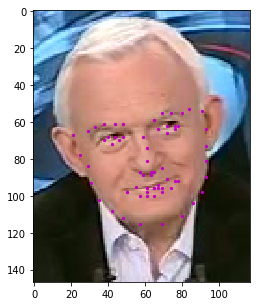

In [74]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 100
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('./data/training/', image_name)), key_pts)
plt.show()

## Dataset类与转换

为了准备训练我们的数据，我们要使用PyTorch的Dataset类。这段代码大部分都是[PyTorch 数据加载教程](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)中代码的修改版。

#### Dataset类

``torch.utils.data.Dataset``是一个表示数据集的抽象类。这个类可以让我们加载批量的图像/关键点数据，并统一地将转换应用于我们的数据，例如，为了训练神经网络，重新缩放和归一化化图像。


你的自定义数据集应继承``Dataset``并覆盖以下方法：

-  ``__len__`` ，从而使``len(dataset)``返回数据集的大小。

-  ``__getitem__`` ，用于支持索引，使``dataset[i]`` 可
     用于获取第i个图像/关键点数据样本。

接下来，让我们为人脸关键点数据集创建一个dataset类。我们要读取``__init__``中的CSV文件，但将图像的读取留给``__getitem__``。这就是高效存储，因为所有图像都不是一次性存储在内存中，而是根据需要读取。

我们的数据集示例将是一个字典``{'image': image, 'keypoints': key_pts}``。该数据集将采用可选参数``transform``，这样的话，任何所需的处理都可以应用于样本。在下一部分，我们要学习的是``transform``的有效性。

In [75]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

现在，我们已经定义了这个类，接下来，我们要做的是实例化该数据集并显示一些图像。

In [76]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                      root_dir='./data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (196, 175, 3) (68, 2)
1 (156, 121, 3) (68, 2)
2 (252, 270, 3) (68, 2)


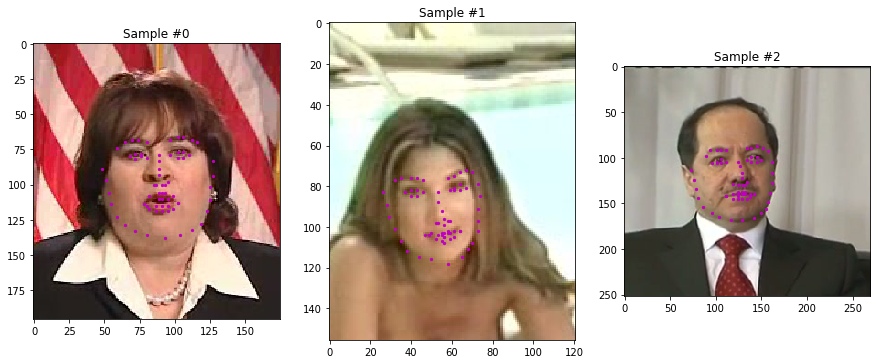

In [77]:
# Display a few of the images from the dataset
num_to_display = 3
fig = plt.figure(figsize=(15,10))

for i in range(num_to_display):
    
    # define the size of images
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])


## 转换

现在，上面的图像尺寸不同，但是，神经网络通常期望的是标准化的图像。因此，我们需要固定的尺寸、颜色范围和坐标的标准化范围。对于PyTorch来说，还需要把numpy列表和数组转换为Tensors。

因此，我们需要编写一些预处理代码。
下面，创建四个转换：

-  ``Normalize``: 将彩色图像转换为范围为[0,1]的灰度值，并将关键点标准化为约[-1,1]的范围
-  ``Rescale``: 将图像重新缩放到所需尺寸。
-  ``RandomCrop``: 随机裁剪图像。
-  ``ToTensor``: 将numpy图像转换为torch图像。


我们将它们编写为可调用类而不是简单函数，这样，每次调用时都不需要传递转换的参数。 为此，我们只需要实现 ``__call__`` 方法就可以了。如果我们需要传入参数，还需要实现``__init__``方法。 我们可以使用类似下面的转换：

In [29]:
tx = Transform(params)
transformed_sample = tx(sample)

NameError: name 'Transform' is not defined

请注意以下这些转换通常是如何应用于图像及其关键点。

In [78]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

## 测试转换

接下来，需要对这些转换进行测试，确保它们按预期运行。查看每个转换时，请注意，在这里，**顺序非常重要**。例如，你不能用一个小于原始图像的值来裁剪图像，而且原始图像的尺寸会有所不同。但是，如果首先选择重新缩放原始图像，则可以将其裁剪为小于重新缩放尺寸的任何尺寸。

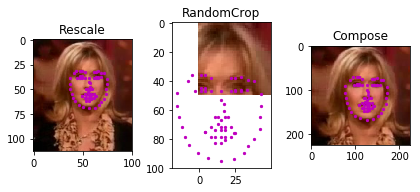

In [79]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

## 创建转换后的数据集

下面，我们需要使用转换获取相同形状的灰度图像。通过输出结果数据的形状来验证转换的工作原理（输出的几个示例应该显示出一致的张量大小）。

In [80]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)


In [83]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())


Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


## 数据迭代与批处理

现在，我们使用``for``循环迭代这些数据，但是我们错过了很多PyTorch的数据集功能，特别是下列这些功能：

-  批量处理数据
-  置乱数据
-  使用``multiprocessing``工作程序并行加载数据。

而``torch.utils.data.DataLoader``是一个提供所有这些功能的迭代器。在*下一个*notebook中，需要批量加载数据来训练神经网络时，我们就会看到这个它的这个作用！

---



## 准备训练你的神经网络吧！

到目前为止，你已经了解了如何加载与转换数据，也为构建一个用于训练这些数据的神经网络做好了准备。

在下一个notebook中，你的任务是创建一个用于人脸关键点检测的CNN。